## Create A Network Grid from Raster Grid

This notebook takes an .asc raster file representing a DEM and extracts a channel network from the topography using the [ChannelProfiler](https://landlab.readthedocs.io/en/master/reference/components/channel_profiler.html). It then uses this extracted channel network to create a NetworkModelGrid.

In [1]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
import pandas as pd

#landlab modules
from landlab.grid.network import NetworkModelGrid
from landlab.plot import graph
from landlab import RasterModelGrid
from landlab.io import read_esri_ascii
from landlab import imshow_grid_at_node
from landlab.components import FlowAccumulator, ChannelProfiler
from landlab.components import DepressionFinderAndRouter

## Import a DEM
Setup this notebook to draw DEM data for the Hugo Site from the overland_flow tutorial folder.

In [2]:
tutorial_dir = os.path.dirname(os.getcwd())
raster_fn = os.path.join(tutorial_dir, 'overland_flow/hugo_site.asc') #mac
# raster_fn = os.path.join(tutorial_dir, 'overland_flow\\hugo_site.asc') #windows

Import the Hugo Site as a RasterModelGrid and visualize:

C:\Users\sahrendt\Anaconda3\envs\landlab_notebooks\lib\site-packages\landlab\plot\imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("pink"))
  cmap.set_bad(color=color_for_closed)
C:\Users\sahrendt\Anaconda3\envs\landlab_notebooks\lib\site-packages\landlab\plot\imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


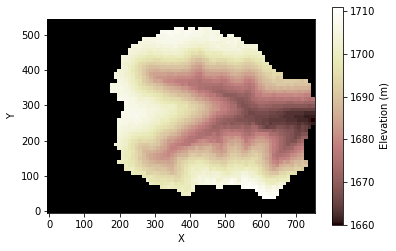

In [3]:
rmg, z = read_esri_ascii(raster_fn, name='topographic__elevation')
rmg.status_at_node[rmg.nodes_at_right_edge] = rmg.BC_NODE_IS_FIXED_VALUE
rmg.status_at_node[np.isclose(z, -9999.)] = rmg.BC_NODE_IS_CLOSED


plt.figure()
imshow_grid_at_node(rmg, z, colorbar_label='Elevation (m)')
plt.show()

## Find flow accumulation:

Find where water will flow using the FlowAccumulator package:

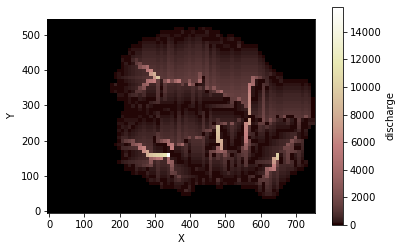

In [4]:
fa = FlowAccumulator(rmg, 
                     'topographic__elevation',
                     flow_director='FlowDirectorSteepest')
fa.run_one_step()

imshow_grid_at_node(rmg,
                    rmg.at_node['surface_water__discharge'],
                    colorbar_label='discharge')

Yuck, that doesn't look like a very well defined channel network, let's fill in those depressions that are affecting the flow and then reroute it:

In [5]:
df_4 = DepressionFinderAndRouter(rmg)
df_4.map_depressions()

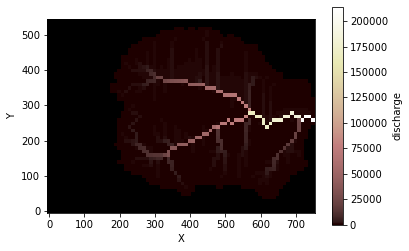

In [6]:
imshow_grid_at_node(rmg,
                    rmg.at_node['surface_water__discharge'],
                    colorbar_label='discharge')

That looks better! 

## Use the channel profiler to extract channels:
* note, toggle minimum channel threshhold to refine network!

C:\Users\sahrendt\Anaconda3\envs\landlab_notebooks\lib\site-packages\landlab\plot\imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("pink"))
  cmap.set_bad(color=color_for_closed)
C:\Users\sahrendt\Anaconda3\envs\landlab_notebooks\lib\site-packages\landlab\plot\imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


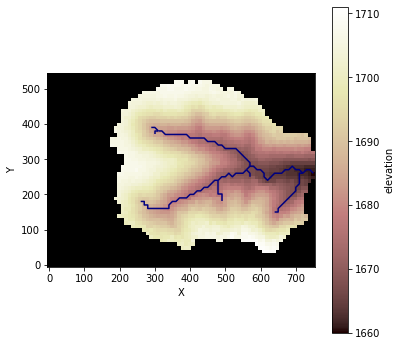

In [23]:
min_channel_thresh = 8000

profiler = ChannelProfiler(
    rmg,
    number_of_watersheds=1,
    minimum_channel_threshold=min_channel_thresh,
    main_channel_only=False,
    cmap='jet',
)
profiler.run_one_step()

plt.figure(figsize = (6,6))
profiler.plot_profiles_in_map_view(colorbar_label='elevation')

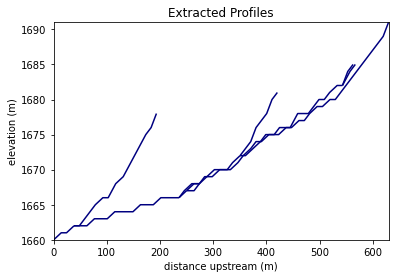

In [24]:
profiler.plot_profiles(xlabel='distance upstream (m)',
                  ylabel='elevation (m)')

## Get network-grid nodes from channel.

Extract x,y network model grid (nmg) nodes from raster model grid (rmg) for each deliniated channel segment:
* Note: both of the following should be considered when setting node spacing as it is known to screw up grid connectivity
    * d_node_spacing cannot be longer than shortest link segment (should create exception for this)
    * d_node_spacing should be greater than grid resolution

In [28]:
d_node_spacing = 30 #units to space nodes, must be greater than grid resolution
x_of_nodes = np.array([]) #empty list to store x locations of network model grid nodes
y_of_nodes = np.array([]) #empty list to store y locations of network model grid nodes
rmg_nodes = np.array([]) #empty list to store raster model grid node corresponding to each network model grid node
colors_nodes = [] #empty list to store colors corresponding to each channel segment
nodes_per_segment = [] #empty list to store number of nodes in each channel segment

#DEV ONLY: keep track of nodes per seg as explicit x and y locations (only toggle if using below)
# x_of_nodes = []
# y_of_nodes = []
links = []
node_xy = []

#would be ideal to also create dictionary here that stores rmg cells along each link to tie rmg properties to nmg
#nmg_cells_on_link = {}

#obtain watershed key
ws_keys = [k for k in profiler.data_structure.keys()]

#sent message if there is more than 1 watershed (code is not currently set up to handle multipe watersheds)
if len(ws_keys) > 1:
    print('more than one watershed in DEM, unable to deliniate network properly')

#access number of channel segments
n_channel_segs = len(profiler.data_structure[ws_keys[0]])
#generate random colors to keep track of channel segs for plotting
colors = [list(np.random.random(3)) for i in range(n_channel_segs)] 

#find the nodes of the start and end index of each segment
ws_start =[ws_seg[0] for ws_seg in profiler.data_structure[ws_keys[0]].keys()] 
ws_end = [ws_seg[1] for ws_seg in profiler.data_structure[ws_keys[0]].keys()]

#loop through each segment
for i, seg_key in enumerate(profiler.data_structure[ws_keys[0]].keys()):
    #access individual segment
    seg_i = profiler.data_structure[ws_keys[0]][seg_key] 
    #print(seg_i)
    # create array of idealized node locations using previously specified distance between nodes
    node_locs = np.arange(seg_i['distances'][0], seg_i['distances'][-1], d_node_spacing)
    n_possible_nodes = len(node_locs)
    nodes_per_segment.append(n_possible_nodes)
    
    #Find the index of the nearest channel cells to idealized node locations:
    idx_nodes = [np.abs(seg_i['distances'] - loc).argmin() for loc in node_locs]
    
    #obtain list of raster model grid nodes corresponding to channel nodes
    rmg_nodes_i = seg_i['ids'][idx_nodes]
    rmg_nodes = np.append(rmg_nodes, rmg_nodes_i) #append to list that will connect rmg node values to nmg
    
    #append x,y values to list of network model grid nodes from raster model grid
    x_of_nodes = np.append(x_of_nodes, rmg.x_of_node[rmg_nodes_i])
    y_of_nodes = np.append(y_of_nodes, rmg.y_of_node[rmg_nodes_i])
    
    #find links for x,y values
    for n in range(0,n_possible_nodes-1):

        head_node_xy = (rmg.x_of_node[seg_i['ids'][idx_nodes[n]]], rmg.y_of_node[seg_i['ids'][idx_nodes[n]]])
        tail_node_xy = (rmg.x_of_node[seg_i['ids'][idx_nodes[n+1]]], rmg.y_of_node[seg_i['ids'][idx_nodes[n+1]]])
            
        #the code below is taken from the read_shapefile landlab code
            
        # we should expect that the head node and tail node of later links will
        # already be part of the model grid. So we check, and add the nodes,
        # if they don't already exist.

        if head_node_xy not in node_xy:
            node_xy.append(head_node_xy)

        if tail_node_xy not in node_xy:
            node_xy.append(tail_node_xy)

        # get the index of the head and tail node index.
        head_node__node_id = node_xy.index(head_node_xy)
        tail_node__node_id = node_xy.index(tail_node_xy)

        # append the head and tail node ids to the link array
        links.append((head_node__node_id, tail_node__node_id))
            
        # check to see if the last node needs to be connected to the start of another segment
        if n == n_possible_nodes-2:
            if seg_i['ids'][-1] in ws_start:
                #Find the start segment to figured out the tail_node 
                seg_n = profiler.data_structure[ws_keys[0]][(ws_start[ws_start.index(seg_i['ids'][-1])],
                                                             ws_end[ws_start.index(seg_i['ids'][-1])])]
                
                head_node_xy = (rmg.x_of_node[seg_i['ids'][idx_nodes[n+1]]], rmg.y_of_node[seg_i['ids'][idx_nodes[n+1]]])
                tail_node_xy = (rmg.x_of_node[seg_n['ids'][0]], rmg.y_of_node[seg_n['ids'][0]])
                
                #the code below is taken from the read_shapefile landlab code
            
                # we should expect that the head node and tail node of later links will
                # already be part of the model grid. So we check, and add the nodes,
                # if they don't already exist.

                if head_node_xy not in node_xy:
                    node_xy.append(head_node_xy)

                if tail_node_xy not in node_xy:
                    node_xy.append(tail_node_xy)

                # get the index of the head and tail node index.
                head_node__node_id = node_xy.index(head_node_xy)
                tail_node__node_id = node_xy.index(tail_node_xy)

                # append the head and tail node ids to the link array
                links.append((head_node__node_id, tail_node__node_id))
       
    #DEV ONLY: keep track of nodes per seg as explicit x and y locations
#     x_of_nodes.append(rmg.x_of_node[rmg_nodes_i])
#     y_of_nodes.append(rmg.y_of_node[rmg_nodes_i])
    
    #add colors to correspond to each segment (this is just for dev plotting and can be removed later)
    for n in range(len(rmg_nodes_i)):
        colors_nodes.append(colors[i])

print(links)     
#get unique nodes
xy_df = pd.DataFrame({'x': x_of_nodes, 'y': y_of_nodes})
uniq_x_of_nodes = xy_df.drop_duplicates()['x'].values
uniq_y_of_nodes = xy_df.drop_duplicates()['y'].values

#print(x_of_nodes)
#print(y_of_nodes)


[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (2, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22), (22, 23), (23, 24), (24, 25), (26, 27), (27, 28), (28, 29), (29, 30), (30, 31), (31, 32), (30, 33), (33, 34), (34, 35), (35, 36), (36, 37), (37, 38), (38, 39), (39, 40), (40, 41)]


In [29]:
from landlab.graph.graph import NetworkGraph
# Create a Network Model Grid.
x_of_node, y_of_node = zip(*node_xy)

# We want to ensure that we maintain sorting, so start by creating an
# unsorted network graph and sorting.
# The sorting is important to ensure that the fields are assigned to
# the correct links.
graph_net = NetworkGraph((y_of_node, x_of_node), links=links, sort=False)
sorted_nodes, sorted_links, sorted_patches = graph_net.sort()

# use the sorting information to make a new network model grid.
grid = NetworkModelGrid(
    (np.asarray(y_of_node)[sorted_nodes], np.asarray(x_of_node)[sorted_nodes]),
    np.vstack((graph_net.node_at_link_head, graph_net.node_at_link_tail)).T,
)

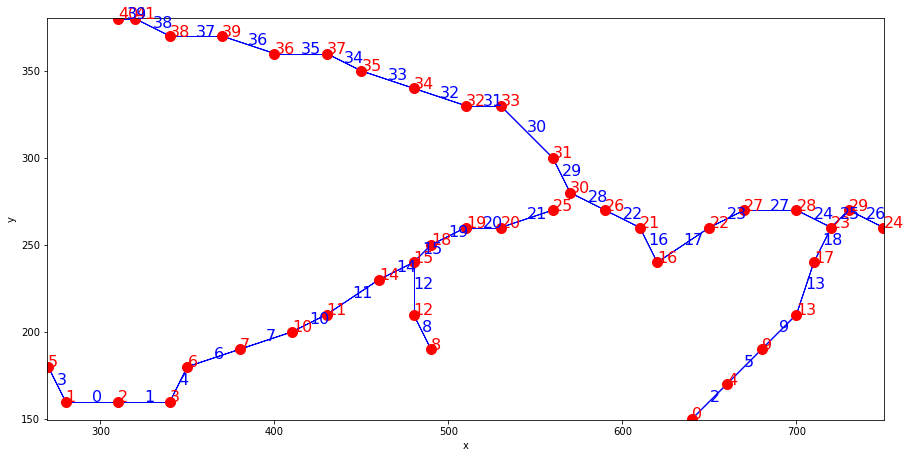

In [30]:
plt.figure(figsize = (15,15))
# profiler.plot_profiles_in_map_view(colorbar_label='elevation')
plt.scatter(x_of_nodes, y_of_nodes, c=colors_nodes, s=30, zorder=2)
graph.plot_graph(grid, at="node,link")

### Helpful plots for developing correct link connections from ChannelProfiler:
* Plot nodes colored by channel segment:

C:\Users\sahrendt\Anaconda3\envs\landlab_notebooks\lib\site-packages\landlab\plot\imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("pink"))
  cmap.set_bad(color=color_for_closed)
C:\Users\sahrendt\Anaconda3\envs\landlab_notebooks\lib\site-packages\landlab\plot\imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


Text(0.5, 1.0, 'Network Nodes colored by channel segment')

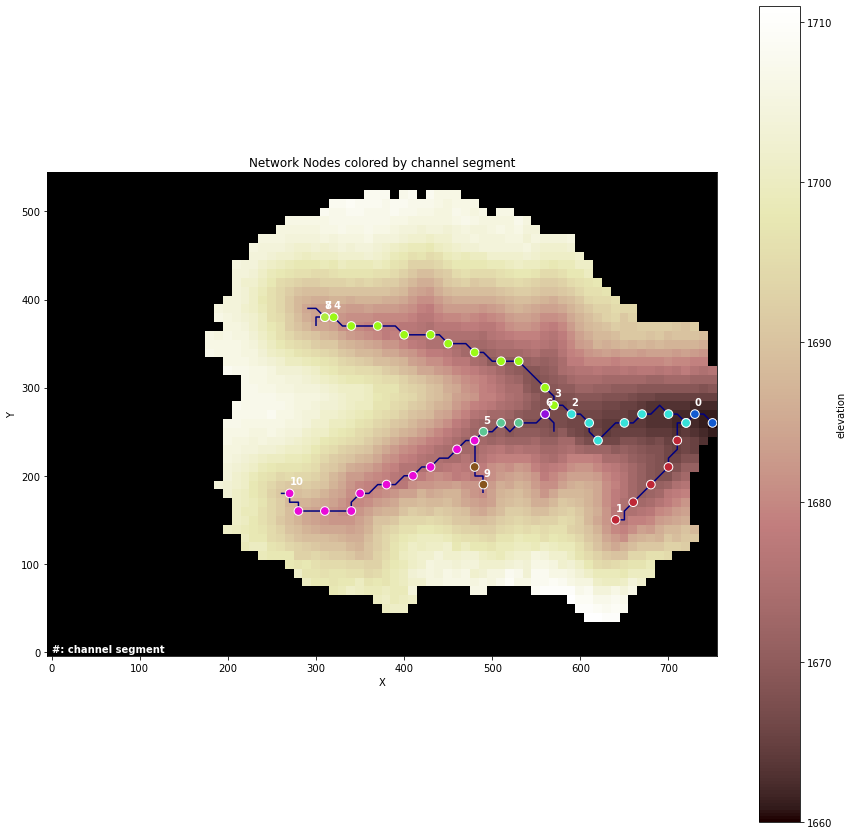

In [31]:
plt.figure(figsize = (15,15))
profiler.plot_profiles_in_map_view(colorbar_label='elevation')
plt.scatter(x_of_nodes, y_of_nodes, c=colors_nodes, s=75, zorder=2, edgecolor='white')

#hacky way to label channel segments with #s -------
node_id = 0 #dummy counter
idx_x = [] #store indexes to acces x,y location of last node on channel
#loop through channels, get node index
for node_len in nodes_per_segment:
    node_id+=node_len
    idx_x.append(node_id-1)
#plot numbers at last node for each channel seg
for i in range(n_channel_segs):
    plt.text(x_of_nodes[idx_x[i]],
             y_of_nodes[idx_x[i]]+10,
             '%d'%i,
             color='white',
             fontweight='bold')
plt.text(0,0,
         '#: channel segment',
         color='white',
         fontweight='bold')
#---------------------------------------------------
plt.title('Network Nodes colored by channel segment')

In [13]:
nodes_per_segment

[2, 7, 9, 5, 14, 3, 12]

Plot unique network nodes:

Text(0.5, 1.0, 'Unique Network Nodes')

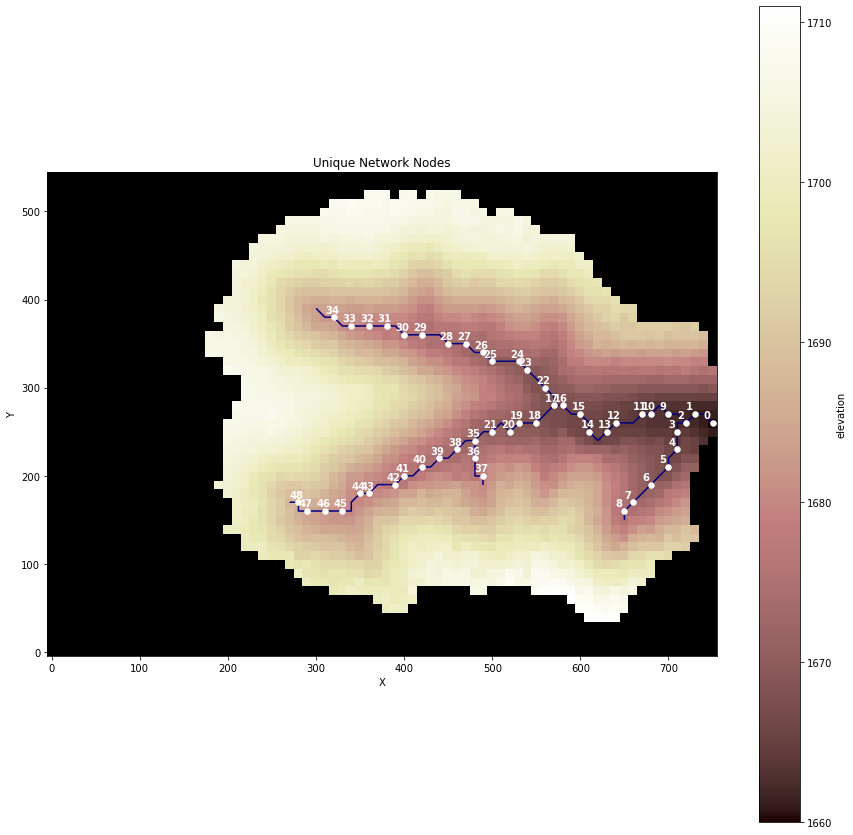

In [21]:
plt.figure(figsize = (15,15))
profiler.plot_profiles_in_map_view(colorbar_label='elevation')
plt.scatter(uniq_x_of_nodes, uniq_y_of_nodes, s=30, c='white', zorder=2)
for i, (x,y) in enumerate(zip(uniq_x_of_nodes, uniq_y_of_nodes)):
    plt.text(x-10,y+5,
            '%d'%i,
             color='white',
            fontweight='bold')
#---------------------------------------------------
plt.title('Unique Network Nodes')